In [106]:
import itertools
import warnings 
import re
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns
import sympy
from scipy import stats
from collections import OrderedDict
from risk_helpers import *

In [107]:
%matplotlib inline
pd.set_option('display.precision',2)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format',lambda x: '%.4f' % x)

In [108]:
df = pd.read_csv(r'C:\Users\Iulia\Desktop\CreditRisk\credit_risk_dataset.csv')

In [109]:
# Compute missing percentage
missing_percentages = compute_missing_percentage(df)

# Print missing percentages
for column, percentage in missing_percentages.items():
    print(f"{column}: {percentage:.2f}%")

person_age: 0.00%
person_income: 0.00%
person_home_ownership: 0.00%
person_emp_length: 2.75%
loan_intent: 0.00%
loan_grade: 0.00%
loan_amnt: 0.00%
loan_int_rate: 9.56%
loan_status: 0.00%
loan_percent_income: 0.00%
cb_person_default_on_file: 0.00%
cb_person_cred_hist_length: 0.00%


In [110]:
# Delete features with missing percentage above 15%
delete_features_above_threshold(df, 15)

# Replace outliers with whiskers using default multiplier
replace_outliers_with_whiskers(df)

In [111]:
# Define the target variable and independent variables
target = 'loan_status'
independent_vars = list(df.columns[df.columns != target])

# Split the data into training and validation sets
train_data, valid_data = train_test_split(df, test_size=0.3, random_state=42)

In [112]:
# Fill missing values with median for numeric and mode for categorical
fill_missing_values(train_data)
fill_missing_values(valid_data)

# Check the resulting dataframe
train_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
12657,25.0000,66300.0000,MORTGAGE,9.0000,MEDICAL,A,1700.0000,6.7600,1,0.0200,N,4.0000
11611,22.0000,75000.0000,MORTGAGE,6.0000,MEDICAL,B,23000.0000,9.2500,0,0.3300,N,2.0000
18223,31.0000,105400.0000,RENT,2.0000,MEDICAL,D,23000.0000,15.3100,1,0.2000,N,5.0000
24772,35.0000,75000.0000,MORTGAGE,5.0000,PERSONAL,B,5000.0000,8.7000,0,0.0700,N,9.0000
30770,36.0000,65000.0000,MORTGAGE,6.0000,EDUCATION,C,23000.0000,15.2700,0,0.3600,Y,14.0000


In [113]:
# apply woe transform to the dataframe
data = woe_transform_dataframe(train_data, target_col='loan_status', event=1, bins=10)

# Obtain the WoE dictionary using woe_transform_dataframe
woe_dict = woe_transform_dataframe(train_data, target_col='loan_status', event=1, bins=10)

In [114]:
# Transform the original DataFrame using the WoE dictionary
transformed_df = transform_to_woe(train_data, woe_dict)

# Assuming 'validation_df' is your validation dataset and 'woe_dict' is the WoE dictionary obtained from the training dataset
transformed_valid_df = transform_to_woe(valid_data, woe_dict)

In [115]:
transformed_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
12657,-0.0236,-0.3659,-0.6536,-0.3056,0.2637,-0.9028,-0.0860,-1.1256,1,-0.8561,-0.2076,0.0385
11611,0.1166,-0.5169,-0.6536,-0.1732,0.2637,-0.3674,0.2986,-0.4091,0,1.4685,-0.2076,0.0472
18223,-0.0412,NaN,0.4997,0.2035,0.2637,1.6469,0.2986,1.5327,1,-0.1685,-0.2076,-0.0473
24772,NaN,-0.5169,-0.6536,-0.2488,-0.1101,-0.3674,-0.0767,-0.8332,0,-0.7152,-0.2076,-0.0574
30770,NaN,-0.3659,-0.6536,-0.1732,-0.2574,-0.0765,0.2986,1.5327,0,NaN,-0.2076,NaN


In [116]:
# Fill missing values with median for numeric and mode for categorical
fill_missing_values(transformed_df)
fill_missing_values(transformed_valid_df)

In [117]:
transformed_valid_df.loan_percent_income.value_counts(dropna=False)

-0.7141    2135
-0.4248    2126
-0.7152    1601
-0.1685    1376
-0.0989     798
-0.8561     659
0.1795      588
1.4685      492
Name: loan_percent_income, dtype: int64

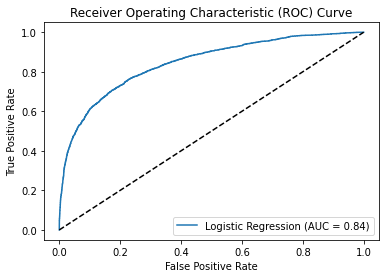

In [118]:
# Build the logistic regression model
X_train = transformed_df[independent_vars]
y_train = transformed_df[target]
model = LogisticRegression()
model.fit(X_train, y_train)

# Model validation
X_valid = transformed_valid_df[independent_vars]
y_valid = transformed_valid_df[target]
y_pred = model.predict(X_valid)
y_pred_proba = model.predict_proba(X_valid)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
auc = roc_auc_score(y_valid, y_pred_proba)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# # Perform sensitivity analysis (example with age variable)
# sensitivity_variable = 'person_age'
# sensitivity_values = [0.9, 1.0, 1.1]  # Adjust the variable by 10% in each case

# for value in sensitivity_values:
#     X_sensitivity = transformed_valid_df[independent_vars].copy()
#     X_sensitivity[sensitivity_variable] *= value  # Adjust the variable
#     y_sensitivity = transformed_valid_df[target]
    
#     # Calculate performance metrics for sensitivity analysis
#     y_pred_sensitivity = model.predict(X_sensitivity)
#     y_pred_proba_sensitivity = model.predict_proba(X_sensitivity)[:, 1]
#     accuracy_sensitivity = accuracy_score(y_sensitivity, y_pred_sensitivity)
#     precision_sensitivity = precision_score(y_sensitivity, y_pred_sensitivity)
#     recall_sensitivity = recall_score(y_sensitivity, y_pred_sensitivity)
#     f1_sensitivity = f1_score(y_sensitivity, y_pred_sensitivity)
#     auc_sensitivity = roc_auc_score(y_sensitivity, y_pred_proba_sensitivity)

#     print(f"Sensitivity Value: {value}")
#     print(f"Accuracy: {accuracy_sensitivity}")
#     print(f"Precision: {precision_sensitivity}")
#     print(f"Recall: {recall_sensitivity}")
#     print(f"F1 Score: {f1_sensitivity}")
#     print(f"AUC: {auc_sensitivity}")
#     print("-------------------------------------")

In [119]:
def calculate_frequencies(df):
    frequencies = {}
    
    for col in df.columns:
        values = df[col].value_counts(normalize=True)
        frequencies[col] = values
    
    return frequencies

freq_counts = calculate_frequencies(X_valid)
for col, values in freq_counts.items():
    print(f"Frequencies for column '{col}':")
    print(values)
    print()

Frequencies for column 'person_age':
-0.0236   0.2808
-0.0293   0.2261
0.1166    0.1516
0.0072    0.1223
-0.1387   0.0913
-0.0412   0.0654
-0.0022   0.0626
Name: person_age, dtype: float64

Frequencies for column 'person_income':
-0.1479   0.2927
0.3746    0.1903
-0.3659   0.1576
0.8316    0.1289
-0.5169   0.1096
-0.9079   0.0646
-0.9583   0.0564
Name: person_income, dtype: float64

Frequencies for column 'person_home_ownership':
0.4997    0.5060
-0.6536   0.4118
-1.2250   0.0781
0.3783    0.0042
Name: person_home_ownership, dtype: float64

Frequencies for column 'person_emp_length':
0.0264    0.3101
0.3048    0.2158
-0.1732   0.1454
0.2035    0.1160
-0.2488   0.0951
-0.3056   0.0637
-0.3589   0.0539
Name: person_emp_length, dtype: float64

Frequencies for column 'loan_intent':
-0.2574   0.1995
0.2637    0.1891
-0.4644   0.1786
-0.1101   0.1680
0.3455    0.1545
0.1864    0.1104
Name: loan_intent, dtype: float64

Frequencies for column 'loan_grade':
-0.9028   0.3302
-0.3674   0.3190
-0.

In [120]:
import numpy as np
from scipy.stats import chi2

def homogeneity_of_odds(y_true, y_pred_proba, num_bins=10):
    num_samples = len(y_true)
    bin_edges = np.linspace(0, 1, num_bins + 1)
    observed_freq = np.histogram(y_pred_proba, bins=bin_edges)[0]
    
    # Find unique bins with non-zero observed frequencies
    non_zero_bins = np.nonzero(observed_freq)[0]
    
    # Calculate expected frequencies
    expected_freq = np.zeros_like(observed_freq, dtype=float)
    expected_freq[non_zero_bins] = np.histogram(y_pred_proba[y_true == 1], bins=bin_edges)[0]
    expected_freq[non_zero_bins] += 1e-8  # Add small epsilon value to avoid division by zero
    expected_freq[non_zero_bins] /= np.sum(expected_freq[non_zero_bins])
    expected_freq[non_zero_bins] *= np.sum(observed_freq[non_zero_bins])
    
    # Calculate degrees of freedom
    df = num_bins - len(non_zero_bins)
    
    # Calculate the chi-square statistic
    chi2_stat = np.sum((observed_freq[non_zero_bins] - expected_freq[non_zero_bins])**2 / expected_freq[non_zero_bins])
    
    # Calculate the p-values
    p_value = 1.0 - chi2.cdf(chi2_stat, df)     
    
    return chi2_stat, p_value

chi2_stat, p_value = homogeneity_of_odds(y_valid, y_pred_proba, num_bins=5)
print("Hosmer-Lemeshow Test:")
print("Chi-square statistic:", chi2_stat)
print("p-value:", p_value)

Hosmer-Lemeshow Test:
Chi-square statistic: 9915.771127500208
p-value: nan


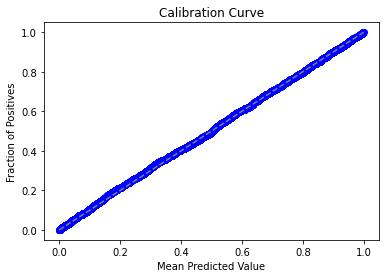

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# Define the observed and expected frequencies
observed_freq = y_valid
expected_freq = y_pred

# Compute the fraction of positives and mean predicted values
fraction_of_positives = np.cumsum(observed_freq) / np.sum(observed_freq)
mean_predicted_value = np.cumsum(expected_freq) / np.sum(expected_freq)

# Plot the calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linestyle='-', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.show()


In [122]:
"""If the calibration curve appears to be aligned closely with the diagonal dashed line, it suggests good calibration. This alignment indicates that the predicted probabilities are well-calibrated and correspond well with the observed frequencies.

In such a case, even if the p-value from the Hosmer-Lemeshow test is NaN or cannot be computed, it does not necessarily imply a problem with the calibration. The visual inspection of the calibration plot is often sufficient to assess the calibration quality.

Therefore, based on the aligned calibration curve, you can conclude that the model's predicted probabilities are well-calibrated and provide accurate estimates of the probabilities of the events."""

"If the calibration curve appears to be aligned closely with the diagonal dashed line, it suggests good calibration. This alignment indicates that the predicted probabilities are well-calibrated and correspond well with the observed frequencies.\n\nIn such a case, even if the p-value from the Hosmer-Lemeshow test is NaN or cannot be computed, it does not necessarily imply a problem with the calibration. The visual inspection of the calibration plot is often sufficient to assess the calibration quality.\n\nTherefore, based on the aligned calibration curve, you can conclude that the model's predicted probabilities are well-calibrated and provide accurate estimates of the probabilities of the events."